In [9]:
#scientific libraries and plotting
import numpy as np
import scipy as scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import awkward as ak

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl
#Using newest versions of all libraries

In [10]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

In [11]:
#variables controlled by the user. Change these to fit your specific needs.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 50 #resolution
"""
#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10"] #for plotting #"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TEV", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH"]
"""

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]
TEST_N_EVENTS = 3000
CUT=True

#Set data paths
if CUT:
    N_EVENTS = 10000
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_3000_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 10000
    TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

MODEL_NAME = "resnet_1687178683_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"
LOAD_FOLDER = "../results/models"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

ampl.use_atlas_style()   

Running on the GPU


In [12]:
#import model
model = ResNet18(img_channels=3, num_classes=CLASSES)
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), padding_mode=circular)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_siz

In [13]:
#Load data
sph_testpath = [Path(TEST_DATAPATHS[0])]
sph_test_data = Hdf5Dataset(sph_testpath, [TEST_LABELS[0]], DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)

bh_testpath = [Path(TEST_DATAPATHS[2])]
bh_test_data = Hdf5Dataset(bh_testpath, [TEST_LABELS[2]], DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)


Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.


In [19]:
#Run the model on just sphalerons and then just black holes
#sph_truth, sph_preds = predict(model, sph_test_data, CLASSES, 1, RES, DEVICE)
sph_truth, sph_preds = shuffle_predict(model, sph_test_data, CLASSES, 1, RES, DEVICE)
#bh_truth, bh_preds = predict(model, bh_test_data, CLASSES, 1, RES, DEVICE)
bh_truth, bh_preds = shuffle_predict(model, bh_test_data, CLASSES, 1, RES, DEVICE)


100%|██████████| 3000/3000 [00:20<00:00, 144.41it/s]


In [20]:
sph_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [sph_truth, sph_preds])))
bh_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_truth, bh_preds])))

Text(0.5, 1.0, 'Prediction on black holes')

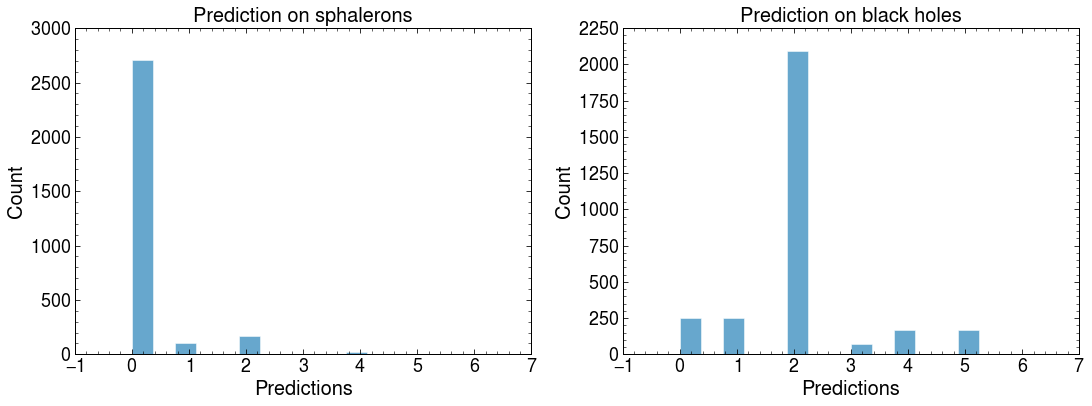

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sn.histplot(sph_df["Predictions"], binrange=[0, CLASSES], ax = ax[0])
ax[0].set_title("Prediction on sphalerons")
sn.histplot(bh_df["Predictions"], binrange=[0, CLASSES], ax= ax[1])
ax[1].set_title("Prediction on black holes")

Text(0.5, 1.0, 'Sphaleron 10 events predictions')

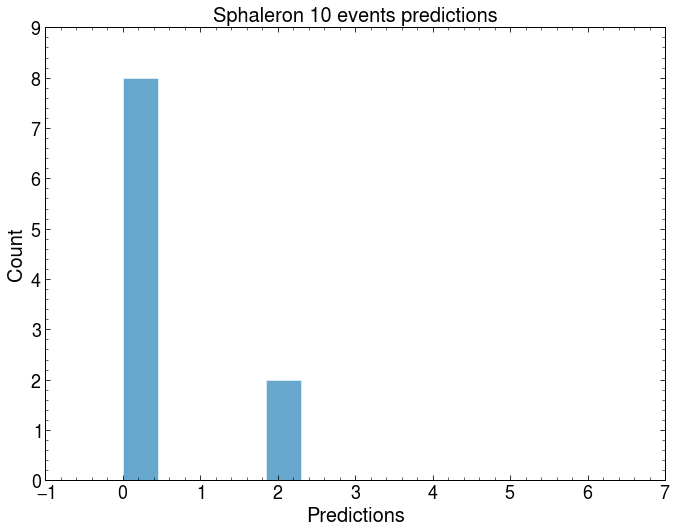

In [31]:
N = 10
k = np.random.randint(0, len(sph_df)-N)
sn.histplot(sph_df["Predictions"][k:k+N], binrange=[0, CLASSES])
plt.title("Sphaleron 10 events predictions")

In [29]:
#chi2 test
from scipy import stats

def chi2_min(x, values):
    #Values is a 2xN vector, [data, theory]
    data = np.array(values[0])
    theory = np.array(values[1])
    return(np.sum([(x*data-theory)**2/(theory)]))

def chi2_method_kazuki(sph, bh, data, verbose=False):
    #Theory 1 is sphalerons
    #Theroy 2 is black holes

    #Number of predicted particles in each class
    N_data_sph = len(data[data["Predictions"]==0])
    N_data_bh = len(data[data["Predictions"]>0])
    N_samp = len(data)

    #normalized predictions for theory 1 and 2 
    n_t1_sph = ((len(sph[sph["Predictions"]==0])/len(sph)))*N_samp 
    n_t1_bh = ((len(sph[sph["Predictions"]>0])/len(sph)))*N_samp 
    n_t2_sph = ((len(bh[bh["Predictions"]==0])/len(bh)))*N_samp 
    n_t2_bh = ((len(bh[bh["Predictions"]>0])/len(bh)))*N_samp 

    value_list1 = [[N_data_sph, N_data_bh], [n_t1_sph, n_t1_bh]]
    value_list2 = [[N_data_sph, N_data_bh], [n_t2_sph, n_t2_bh]]
    
    #Find the x-value which minimizes the chi2 function
    x_value1 = minimize(chi2_min, 0, value_list1).x[0]
    x_value2 = minimize(chi2_min, 0, value_list2).x[0]

    chi2_value1=chi2_min(x_value1, np.array(value_list1))
    chi2_value2=chi2_min(x_value2, np.array(value_list2))

    #p-values
    p_value1 = (1 - stats.chi2.cdf(chi2_value1, 1))
    p_value2 = (1 - stats.chi2.cdf(chi2_value2, 1))

    if verbose:
        print(f"Histogram for data: {[N_data_sph, N_data_bh]}")
        print(f"Histogram sphaleron theory: {[n_t1_sph, n_t1_bh]}")
        print(f"The chi2 value for sphaleron theory is {chi2_value1}. The p-value is {p_value1}")
        print(f"Histogram black holes theory: {[n_t2_sph, n_t2_bh]}")
        print(f"The chi2 value for black holes theory is {chi2_value2}. The p-value is {p_value2}")
    return p_value1, p_value2

def chi2(values):
    #Values is a 2xN vector, [data, theory]
    data = np.array(values[0])
    theory = np.array(values[1])
    return(np.sum([(data-theory)**2/(theory)]))

def chi2_method_pearson(sph, bh, data, verbose=False):
    #Theory 1 is sphalerons
    #Theroy 2 is black holes

    #Number of classified particles in each class
    N_data_sph = len(data[data["Predictions"]==0])
    N_data_bh = len(data[data["Predictions"]>0])
    N_samp = len(data)
    
    #Number of predicted events for theory 1 and 2 
    N_t1_sph = ((len(sph[sph["Predictions"]==0])/len(sph)))*N_samp 
    N_t1_bh = ((len(sph[sph["Predictions"]>0])/len(sph)))*N_samp 
    N_t2_sph = ((len(bh[bh["Predictions"]==0])/len(bh)))*N_samp 
    N_t2_bh = ((len(bh[bh["Predictions"]>0])/len(bh)))*N_samp 
    
    value_list1 = [[N_data_sph, N_data_bh], [N_t1_sph, N_t1_bh]]
    value_list2 = [[N_data_sph, N_data_bh], [N_t2_sph, N_t2_bh]]

    chi2_value1=chi2(np.array(value_list1))
    chi2_value2=chi2(np.array(value_list2))

    #p-values
    p_value1 = (1 - stats.chi2.cdf(chi2_value1, 1))
    p_value2 = (1 - stats.chi2.cdf(chi2_value2, 1))

    if verbose:
        print(f"Histogram for data: {[N_data_sph, N_data_bh]}")
        print(f"Histogram sphaleron theory: {[N_t1_sph, N_t1_bh]}")
        print(f"The chi2 value for sphaleron theory is {chi2_value1}. The p-value is {p_value1}")
        print(f"Histogram black holes theory: {[N_t2_sph, N_t2_bh]}")
        print(f"The chi2 value for black holes theory is {chi2_value2}. The p-value is {p_value2}")
    return p_value1, p_value2


N = 10 #number of events found
k = np.random.randint(0, len(sph_df)-N)
experiment = sph_df[k:k+N]
print(experiment)
print("Sending in sphalerons")
p1, p2 = chi2_method_pearson(sph_df, bh_df, experiment, verbose=True)


     Truth  Predictions
987    0.0          0.0
988    0.0          0.0
989    0.0          4.0
990    0.0          0.0
991    0.0          0.0
992    0.0          0.0
993    0.0          0.0
994    0.0          0.0
995    0.0          0.0
996    0.0          4.0
Sending in sphalerons
Histogram for data: [8, 2]
Histogram sphaleron theory: [9.026666666666666, 0.9733333333333333]
The chi2 value for sphaleron theory is 1.199692438437102. The p-value is 0.27338315860068185
Histogram black holes theory: [0.8366666666666667, 9.163333333333334]
The chi2 value for black holes theory is 66.93054627615402. The p-value is 3.3306690738754696e-16


In [40]:
#p-value as a function of number of events
N_max = 500
N_list = np.arange(2, N_max, 5)
p_values = np.zeros((2, len(N_list)))

for i, n in enumerate(N_list):
    k_list = [np.random.randint(0, len(bh_df)-n) for i in range(0,20)]
    experiments = [bh_df[k:k+n] for k in k_list]
    results = [chi2_method_kazuki(sph_df, bh_df, experiment) for experiment in experiments]
    results = np.average(results, axis=0)
    p_values[0][i] = results[0]
    p_values[1][i] = results[1]

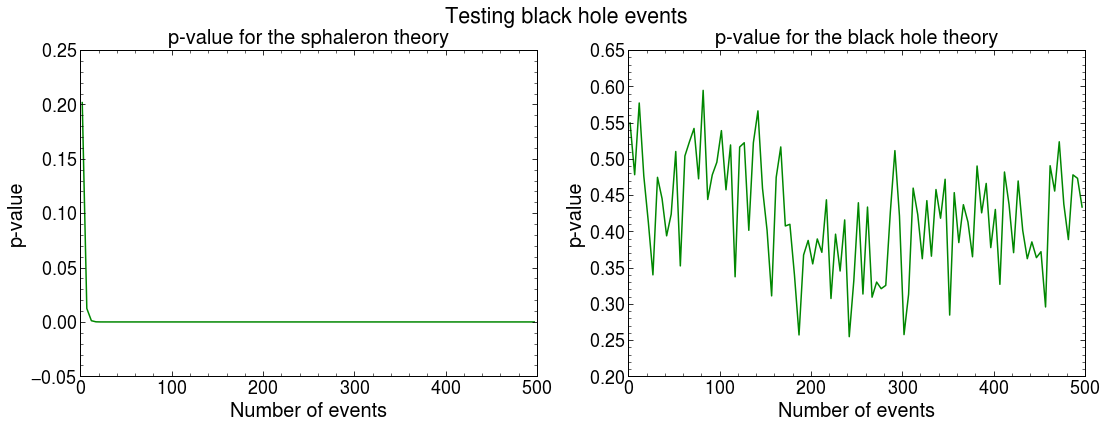

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(N_list, p_values[0])
ax[1].plot(N_list, p_values[1])
ax[0].set_title("p-value for the sphaleron theory")
ax[1].set_title("p-value for the black hole theory")
fig.suptitle("Testing black hole events")

for axis in ax:
    axis.set_xlabel("Number of events")
    axis.set_ylabel("p-value")
    axis.set_xlim(0, N_max)

In [42]:
N_list = np.arange(2, N_max, 5)
p_values = np.zeros((2, len(N_list)))

for i, n in enumerate(N_list):
    k_list = [np.random.randint(0, len(bh_df)-n) for i in range(0,20)]
    experiments = [sph_df[k:k+n] for k in k_list]
    results = [chi2_method_kazuki(sph_df, bh_df, experiment) for experiment in experiments]
    results = np.average(results, axis=0)
    p_values[0][i] = results[0]
    p_values[1][i] = results[1]

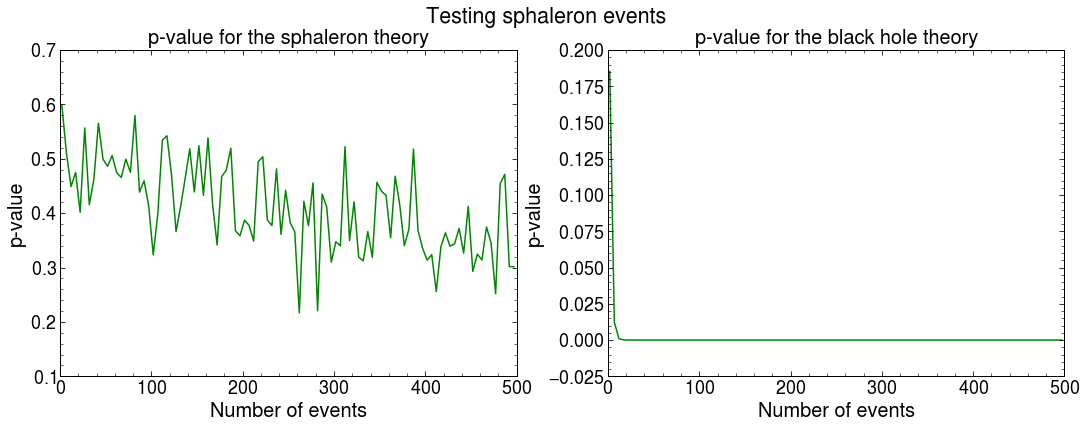

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(N_list, p_values[0])
ax[1].plot(N_list, p_values[1])
ax[0].set_title("p-value for the sphaleron theory")
ax[1].set_title("p-value for the black hole theory")
fig.suptitle("Testing sphaleron events")

for axis in ax:
    axis.set_xlabel("Number of events")
    axis.set_ylabel("p-value")
    axis.set_xlim(0, N_max)